In [2]:
# This block checks for internet connectivity in Kaggle notebooks, as you need an active connection to download necessary libraries and datasets.
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# Ensure we're using the latest versions of the fastai and duckduckgo_search libraries.
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [10]:
from fastai.vision.all import *
import requests

# Ensure that Kaggle notebooks use the latest versions of FastAI and Gradio libraries
!pip install fastai gradio

In [11]:
# Ensure that Kaggle notebooks use the latest versions of FastAI and Gradio libraries
!pip install fastai gradio

In [22]:
!pip install gdown

import gdown

# Define the file ID from Google Drive and the output file
file_id = '1U2PljA7NE57jcSSzPs21ZurdIPXdYZtN'
output_directory = 'clothing_images.zip'

# Use gdown to download the file from Google Drive
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, output_directory, quiet=False)

print("Download completed.")

# Unzip the downloaded file into the appropriate folder
import zipfile

with zipfile.ZipFile(output_directory, 'r') as zip_ref:
    zip_ref.extractall('clothing_images')

print("Dataset extracted.")

Downloading...
From (original): https://drive.google.com/uc?id=1U2PljA7NE57jcSSzPs21ZurdIPXdYZtN
From (redirected): https://drive.google.com/uc?id=1U2PljA7NE57jcSSzPs21ZurdIPXdYZtN&confirm=t&uuid=988d683f-e55f-4bd7-a053-2479aec305d9
To: /kaggle/working/clothing_images.zip
100%|██████████| 6.82G/6.82G [01:55<00:00, 59.0MB/s]


Download completed.
Dataset extracted.


In [23]:
# Data preparation: Create a DataBlock to load the clothing images
clothing_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,  # Assumes that folder names are used as labels (e.g., casual, formal)
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,03:41


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,03:25
1,0.000000,0.000000,0.000000,03:22
2,0.000000,0.000000,0.000000,03:55
3,0.000000,0.000000,0.000000,04:12


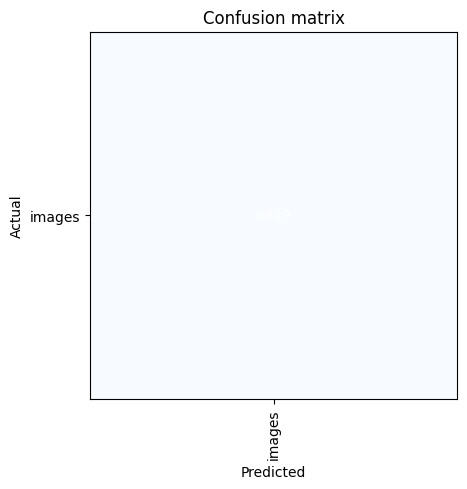

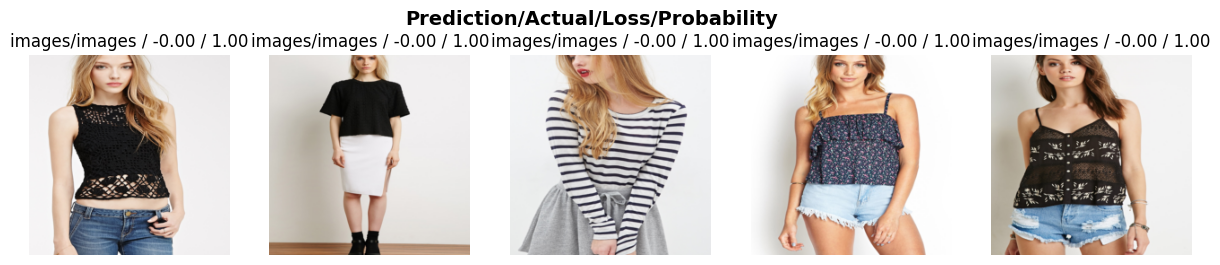

In [24]:
# Create DataLoader to handle batches
dls = clothing_data.dataloaders('clothing_images')

# Optionally show a batch of images to verify dataset
# dls.train.show_batch(max_n=8, nrows=2)

# Model training: Fine-tune a pre-trained ResNet18 model on the clothing dataset
learn = vision_learner(dls, resnet18, metrics=error_rate)

# Fine-tune the model for 4 epochs (you can increase or adjust this)
learn.fine_tune(4)

# Evaluate the model with confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Optionally plot the top losses (to identify images where the model struggles)
interp.plot_top_losses(5, nrows=1)

In [25]:
# Export the trained model so it can be used for inference later
learn.export('clothing_style_classifier.pkl')

<a href="clothing_style_classifier.pkl"> Download clothing_style_classifier.pkl </a>

In [26]:
# Create a Gradio interface for deploying the model
import gradio as gr

# Load the trained model for inference
learn = load_learner('clothing_style_classifier.pkl')

In [27]:
# Define a function to classify clothing images and return the predicted style
def classify_clothing_style(img):
    pred, _, probs = learn.predict(img)
    style_probs = {learn.dls.vocab[i]: float(probs[i]) for i in range(len(learn.dls.vocab))}
    return pred, style_probs

In [28]:
# Build the Gradio interface
demo = gr.Interface(
    fn=classify_clothing_style,
    inputs=gr.Image(type="pil"),  # Image input in PIL format
    outputs=[
        gr.Label(num_top_classes=1, label="Predicted Clothing Style"),  # Top predicted clothing style
        gr.Label(num_top_classes=5, label="Clothing Style Probabilities")  # Probabilities for all styles
    ],
    examples=[  # Example images to test the model
        ["example_style1.jpg"],
        ["example_style2.jpg"],
        ["example_style3.jpg"]
    ],
    title="Clothing Style Classifier",
    description="Upload an image of clothing to classify its style and get similar suggestions."
)

In [29]:
# Launch the Gradio interface locally or on Hugging Face Spaces
demo.launch()

Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Running on public URL: https://5eb2a6783f6c6e401a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
